In [1]:
import sys
import random
import logging
import config
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load(open("simulation_outcome.train.npy", 'rb'))[()]

In [3]:
'''
Check shapes of the data.
'''
print("Keys: ",', '.join([key for key in data.keys()]), "\n")
for key in data.keys():
    if type(data[key]) is np.ndarray: 
        print("Shape %-11s %s" % (key, str(data[key].shape)))

Keys:  y, x, mu, centroids_x, centroids_z, param, z, s, t 

Shape y           (5000, 4, 1)
Shape x           (5000, 3024, 1)
Shape mu          (5000, 4, 1)
Shape centroids_x (4, 3024)
Shape centroids_z (4, 50)
Shape z           (5000, 50, 1)
Shape s           (5000, 4, 1)
Shape t           (5000, 1)


In [10]:
'''
Load data into variables for nicer access.
'''
z = data['z']
c = data['centroids_z']
s = data['s']
mu = data['mu'][:,:,0]
y = data['y'][:,:,0]
x = data['x'][:,:,0]
t = data['t'][:,0]
n_treatments = c.shape[0]
n_samples = z.shape[0]

for i in range(3):
    print("Nr t=%d: %d" % (i, sum(t==i)))
    

Nr t=0: 1205
Nr t=1: 1397
Nr t=2: 1265


In [5]:
'''
Dot product to centroid in topic space. 
Used for treatment assignment and outcome calculation.
'''
dist = np.zeros([n_treatments, n_samples])
for i in range(n_treatments):
    dist[i] = [np.dot(c[i],j) for j in z]

Treatment 2
Min treatment param: [0.04539529]
Max treatment param: [1.]


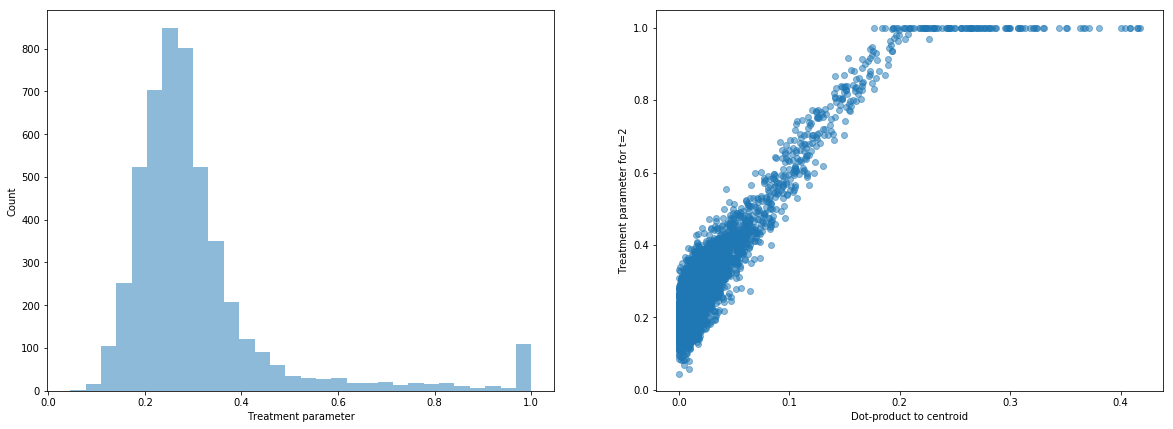

Treatment 0


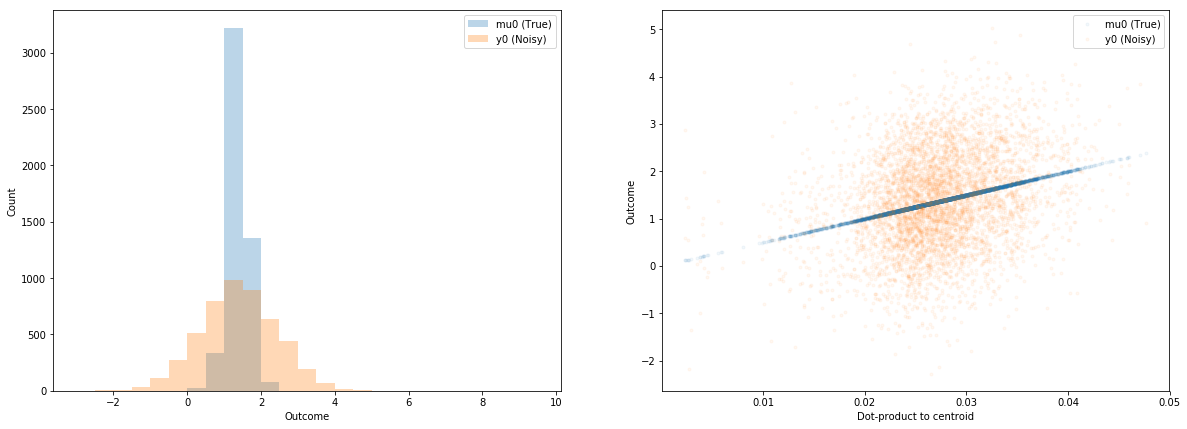

Treatment 1


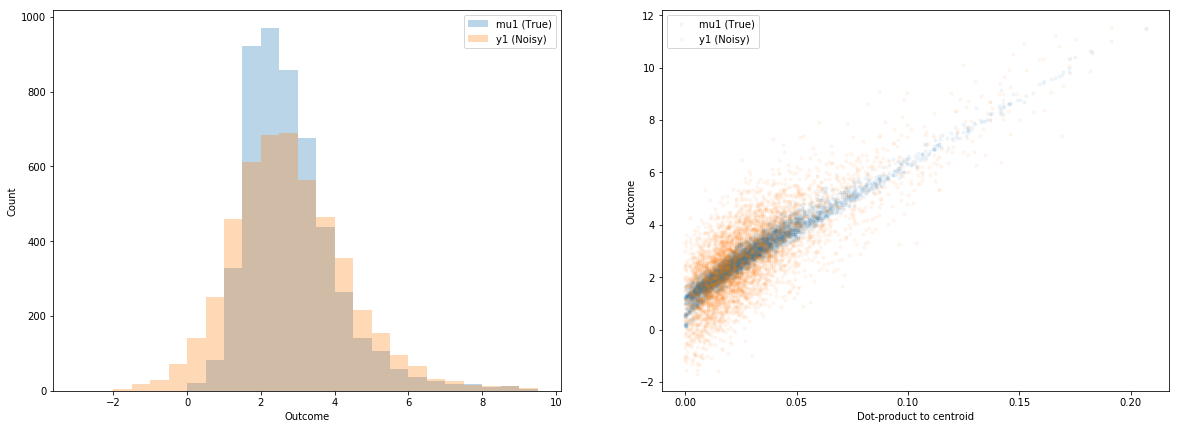

Treatment 2


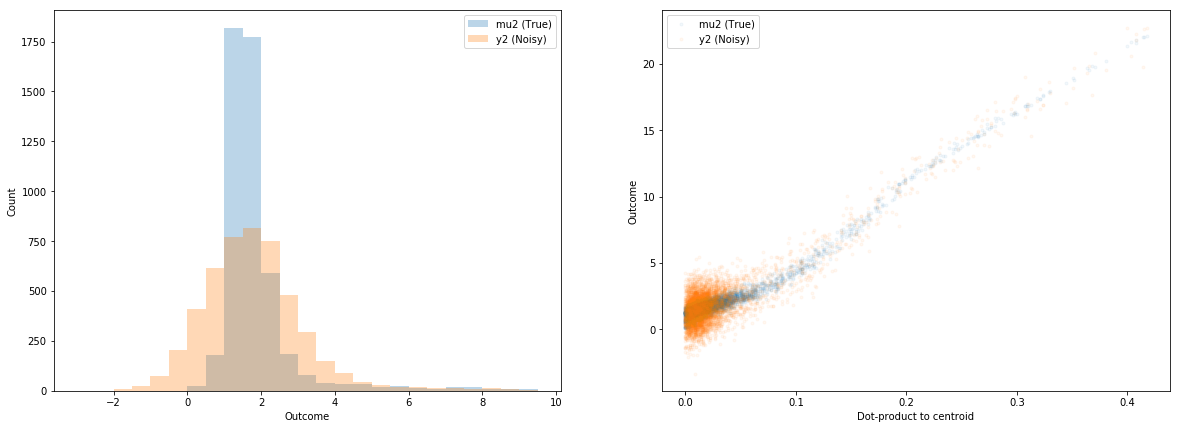

Treatment 3


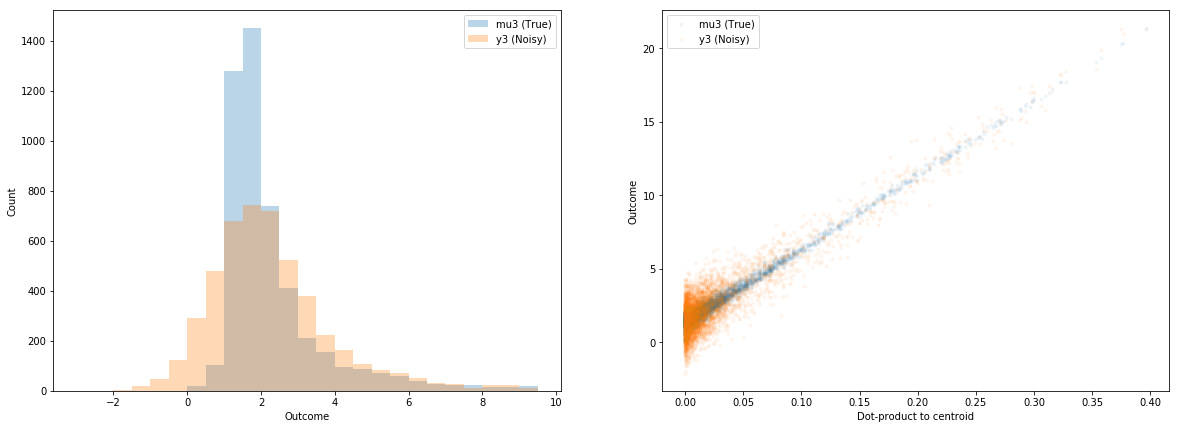

In [6]:
plt.rcParams['figure.figsize'] = (20.0, 7.0)

for i in range(1,n_treatments):
    if data["param"][i-1] > 0:
        print("Treatment %d" % i)
        print("Min treatment strength: "+str(min(s[:,i])))
        print("Max treatment strength: "+str(max(s[:,i])))

        plt.subplot(121)
        plt.hist(s[:,i], bins=30, alpha=0.5, label='s')
        plt.xlabel('Treatment strength')
        plt.ylabel('Count')

        plt.subplot(122)
        plt.plot(dist[i], s[:,i], 'o', alpha=0.5)
        plt.xlabel('Dot-product to centroid')
        plt.ylabel('Treatment strength for t=%d' % i)
        
        plt.show()

for i in range(n_treatments):
    print("Treatment %d" % i)
    plt.subplot(121)
    plt.hist(mu[:,i], bins=np.arange(-3,10,0.5), alpha=0.3, label='mu'+str(i)+" (True)")
    plt.hist(y[:,i], bins=np.arange(-3,10,0.5), alpha=0.3, label='y'+str(i)+" (Noisy)")
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(122)
    plt.plot(dist[i], mu[:,i],'o', alpha=0.05, label='mu'+str(i)+" (True)", marker='.')
    plt.plot(dist[i], y[:,i],'o', alpha=0.05, label='y'+str(i)+" (Noisy)", marker='.')
    plt.xlabel('Dot-product to centroid')
    plt.ylabel('Outcome')
    plt.legend()

    plt.show()

#centroids = 4
dimension of centroids = 3024


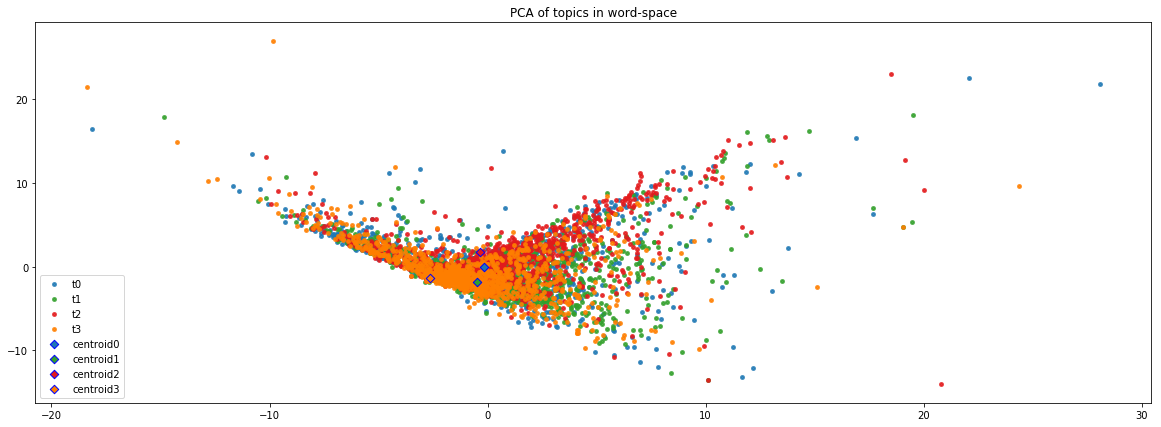

#centroids = 4
dimension of centroids = 50


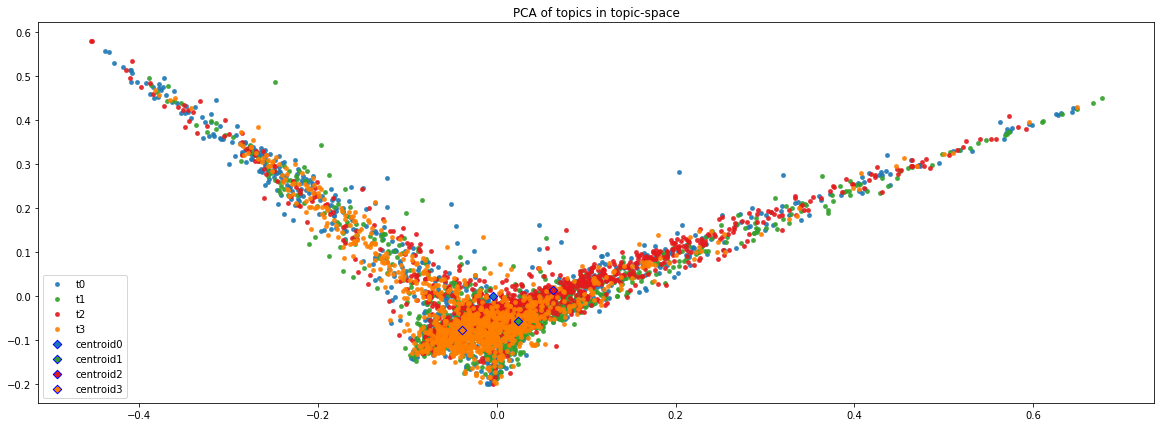

#centroids = 4
dimension of centroids = 50
(5004, 2) (5000, 2) (4, 2)


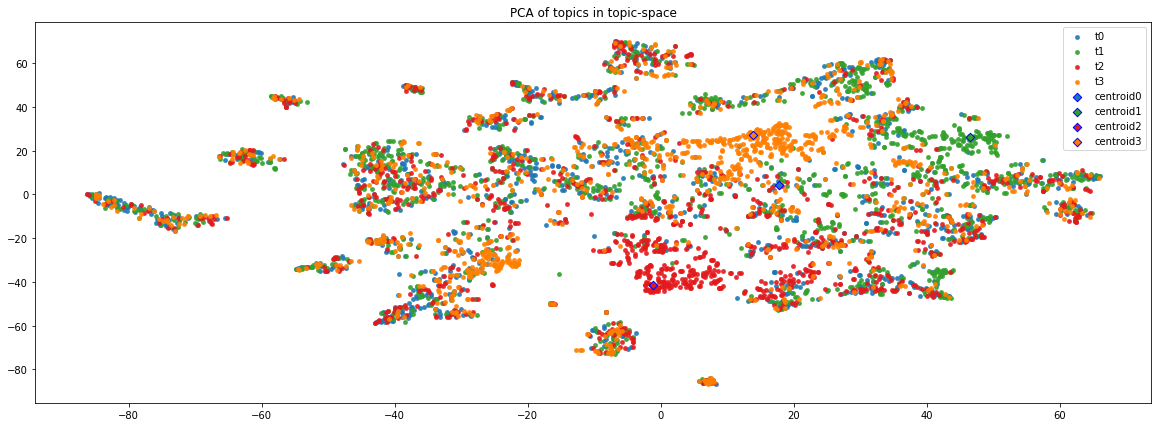

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_DR(data, centroids, space_name, algo="pca"):
    x = data
    c_x = centroids 
    n_treatments = len(centroids)
    
    print("#centroids = %d" % len(c_x))
    print("dimension of centroids = %d" % len(c_x[0]))
    if algo is "pca":
        pca = PCA(n_components=2)
        pca = pca.fit(x)
        x_r = pca.transform(x)
        centroids_r = pca.transform(c_x)

    elif algo is "tsne":
        tsne = TSNE(n_components=2)
        tsne = tsne.fit_transform( np.concatenate((data, centroids)) )
        x_r = tsne[:-n_treatments,:]
        centroids_r = tsne[-n_treatments:,:]
    
    plt.figure()

    cmap_data = plt.cm.get_cmap('Paired')
    colors = [cmap_data(i*2+1) for i in range(n_treatments)]
    
    for color, i, target_name in zip(colors, np.arange(n_treatments), ["t"+str(i) for i in range(n_treatments)]):
        plt.scatter(x_r[t == i,0], x_r[t == i,1], color=color, alpha=0.8, lw=2, label=target_name, marker='.')
    
    for color, i, target_name in zip(colors, np.arange(n_treatments), ["centroid"+str(i) for i in range(n_treatments)]):
        centroid_r = centroids_r[i]
        plt.scatter(centroid_r[0], centroid_r[1], color=color, lw=1, label=target_name, marker='D', edgecolors='b')
    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(algo + ' of topics in ' + space_name)
    plt.show()
    
plot_DR(data['x'][:,:,0], data['centroids_x'], "word-space", algo="pca")
plot_DR(data['z'][:,:,0], c, "topic-space", algo="pca")
plot_DR(data['z'][:,:,0], c, "topic-space", algo="tsne")  # This takes a while